## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 8.73 and accuracy of 0.17
Iteration 100: with minibatch training loss = 0.933 and accuracy of 0.36
Iteration 200: with minibatch training loss = 0.747 and accuracy of 0.38
Iteration 300: with minibatch training loss = 0.744 and accuracy of 0.22
Iteration 400: with minibatch training loss = 0.524 and accuracy of 0.36
Iteration 500: with minibatch training loss = 0.574 and accuracy of 0.28
Iteration 600: with minibatch training loss = 0.429 and accuracy of 0.38
Iteration 700: with minibatch training loss = 0.487 and accuracy of 0.34
Epoch 1, Overall loss = 0.751 and accuracy of 0.301


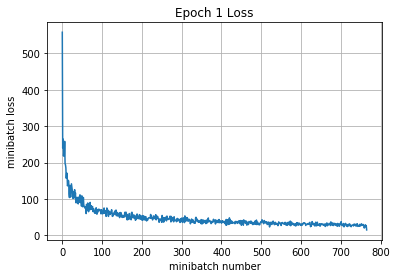

Validation
Epoch 1, Overall loss = 0.43 and accuracy of 0.368


In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [5]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    
    W2 = tf.get_variable("W2", shape=[32*16*16, 1024])
    b2 = tf.get_variable("b2", shape=[1024])
    
    W3 = tf.get_variable("W3", shape=[1024, 10])
    b3 = tf.get_variable("b3", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    conv1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='SAME') + bconv1
    relu1 = tf.nn.relu(conv1)
    bn1 = tf.layers.batch_normalization(conv1, training=is_training)
    max_pool1 = tf.nn.max_pool(bn1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    max_pool1_flat = tf.reshape(max_pool1, shape=[-1, 32*16*16])
    
    layer2_a = tf.nn.xw_plus_b(x=max_pool1_flat, weights=W2, biases=b2)
    layer2_out = tf.nn.relu(layer2_a)
    
    layer3_a = tf.nn.xw_plus_b(x=layer2_out, weights=W3, biases=b3)
    y_out = layer3_a

    return y_out

# y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [6]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
with tf.device("/cpu:0"):
    y_out = complex_model(X,y,is_training) # model must be on cpu, default - gpu
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()
        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

20.8 ms ± 713 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [7]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
y_out = complex_model(X,y,is_training)
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

1.82 ms ± 50.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [8]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
# mean_loss = None
# optimizer = None
loss = tf.nn.softmax_cross_entropy_with_logits(logits=y_out, labels=tf.one_hot(y, depth=10))
mean_loss = tf.reduce_mean(loss)
optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-3)

In [9]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [10]:
# def run_model(session, predict, loss_val, Xd, yd,
#               epochs=1, batch_size=64, print_every=100,
#               training=None, plot_losses=False)

In [11]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 3.27 and accuracy of 0.11
Iteration 100: with minibatch training loss = 2.13 and accuracy of 0.23
Iteration 200: with minibatch training loss = 2.1 and accuracy of 0.36
Iteration 300: with minibatch training loss = 1.59 and accuracy of 0.42
Iteration 400: with minibatch training loss = 1.79 and accuracy of 0.39
Iteration 500: with minibatch training loss = 1.68 and accuracy of 0.36
Iteration 600: with minibatch training loss = 1.55 and accuracy of 0.41
Iteration 700: with minibatch training loss = 1.58 and accuracy of 0.44
Epoch 1, Overall loss = 1.83 and accuracy of 0.392


(1.829746063154571, 0.39183673469387753)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [12]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.63 and accuracy of 0.48


(1.6331759357452393, 0.47999999999999998)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [13]:
# [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
# [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
# [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
# resnet
# densenet

## Define different type of layers

In [73]:
def conv_layer(input_, num_filters, filter_size, use_relu=True, pool_size=None, use_batchnorm=False, p_dropout=None, is_training=None):
    layer = tf.layers.conv2d(input_, filters=num_filters, kernel_size=[filter_size, filter_size], padding='same')
    if use_batchnorm:
        if is_training is None:
            raise Exception("is_training must be a tensor")
        layer = tf.layers.batch_normalization(layer, training=is_training)
    if use_relu:
        layer = tf.nn.relu(layer)
    if pool_size is not None:
        layer = tf.layers.max_pooling2d(layer, pool_size=pool_size, strides=2, padding='same')
    if p_dropout is not None:
        if is_training is None:
            raise Exception("is_training must be a tensor")
        keep_prob = tf.cond(is_training, lambda: tf.constant(p_dropout), lambda: tf.constant(1.0))
        layer = tf.nn.dropout(layer, keep_prob=keep_prob)
    return layer    

In [74]:
def fc_layer(prev_layer, num_units, p_dropout=None, is_training=None):
    fc = tf.layers.dense(prev_layer, num_units)
    if p_dropout is not None:
        if is_training is None:
            raise Exception("is_training must be a tensor")
        keep_prob = tf.cond(is_training, lambda: tf.constant(p_dropout), lambda: tf.constant(1.0))
        fc = tf.nn.dropout(fc, keep_prob=keep_prob)
    return fc

In [99]:
def res_unit(input_layer, is_training, i):
    with tf.variable_scope("res_unit{}".format(i)):
        part1 = tf.layers.batch_normalization(input_layer, training=is_training)
        part2 = tf.nn.relu(part1)
        part3 = tf.layers.conv2d(part2, filters=64, kernel_size=[3, 3], padding="same")
        part4 = tf.layers.batch_normalization(part3, training=is_training)
        part5 = tf.nn.relu(part4)
        part6 = tf.layers.conv2d(part5, filters=64, kernel_size=[3, 3], padding="same")
        out_layer = input_layer + part6
        return out_layer

In [191]:
def dense_unit(input_layer, is_training, i):
    with tf.variable_scope("dense_unit{}".format(i)):
        nodes = []
        layer0 = tf.layers.conv2d(input_layer, filters=64, kernel_size=[3, 3], padding="same")
        layer0 = tf.layers.batch_normalization(layer0, training=is_training)
        layer0 = tf.nn.relu(layer0)
        nodes.append(layer0)
        for _ in range(5):
            layer = tf.concat(nodes, 3)
            layer = tf.layers.conv2d(layer, filters=64, kernel_size=[3, 3], padding="same")
            layer = tf.layers.batch_normalization(layer, training=is_training)
            layer = tf.nn.relu(layer)
            nodes.append(layer)
        return layer

## Define different networks

In [192]:
# [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
# Validation: Epoch 1, Overall loss = 0.617 and accuracy of 0.81 after 60 epochs
def model_conv_relu_pool(X, y, is_training):
    layer1 = conv_layer(X, num_filters=64, filter_size=3, pool_size=3, use_batchnorm=True, p_dropout=0.8, is_training=is_training)
    layer2 = conv_layer(layer1, num_filters=128, filter_size=3, pool_size=3, use_batchnorm=True, p_dropout=0.8, is_training=is_training)
    layer3 = conv_layer(layer2, num_filters=256, filter_size=3, pool_size=3, use_batchnorm=True, p_dropout=0.8, is_training=is_training)
    layer4 = conv_layer(layer3, num_filters=512, filter_size=3, pool_size=3, use_batchnorm=True, p_dropout=0.8, is_training=is_training)
    layer5 = conv_layer(layer4, num_filters=512, filter_size=3, pool_size=3, use_batchnorm=True, p_dropout=0.8, is_training=is_training)
    
    last_conv = layer5
    shape = last_conv.get_shape().as_list()
    dim = np.prod(shape[1:]) 
    layer_conv_flat = tf.reshape(last_conv, [-1, dim])
    layer_fc1 = fc_layer(layer_conv_flat, 2048, p_dropout=0.8, is_training=is_training)
    layer_fc2 = fc_layer(layer_fc1, 1024, p_dropout=0.8, is_training=is_training)
    layer_fc3 = fc_layer(layer_fc2, 512, p_dropout=0.8, is_training=is_training)
    layer_fc4 = fc_layer(layer_fc3, 10)
    
    y_out = layer_fc4
    return y_out

In [248]:
# [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
# Validation: Epoch 1, Overall loss = 0.552 and accuracy of 0.816 after 60 epochs
def model_conv_relu_conv_relu_pool(X, y, is_training):
    layer1 = conv_layer(X, num_filters=64, filter_size=3, pool_size=None, use_batchnorm=True, p_dropout=0.8, is_training=is_training)
    layer2 = conv_layer(layer1, num_filters=128, filter_size=3, pool_size=3, use_batchnorm=True, p_dropout=0.8, is_training=is_training)
    layer3 = conv_layer(layer2, num_filters=128, filter_size=3, pool_size=None, use_batchnorm=True, p_dropout=0.8, is_training=is_training)
    layer4 = conv_layer(layer3, num_filters=256, filter_size=3, pool_size=3, use_batchnorm=True, p_dropout=0.8, is_training=is_training)
    layer5 = conv_layer(layer4, num_filters=256, filter_size=3, pool_size=None, use_batchnorm=True, p_dropout=0.8, is_training=is_training)
    layer6 = conv_layer(layer5, num_filters=512, filter_size=3, pool_size=3, use_batchnorm=True, p_dropout=0.8, is_training=is_training)
    
    last_conv = layer6
    shape = last_conv.get_shape().as_list()
    dim = np.prod(shape[1:]) 
    layer_conv_flat = tf.reshape(last_conv, [-1, dim])
    layer_fc1 = fc_layer(layer_conv_flat, 2048, p_dropout=0.8, is_training=is_training)
    layer_fc2 = fc_layer(layer_fc1, 1024, p_dropout=0.8, is_training=is_training)
    layer_fc3 = fc_layer(layer_fc2, 512, p_dropout=0.8, is_training=is_training)
    layer_fc4 = fc_layer(layer_fc3, 10)
    
    y_out = layer_fc4
    return y_out

In [249]:
# maximum - Overall loss = 0.846 and accuracy of 0.757, epoch 6, batch 64
def model_residual(X, y, is_training):
    with tf.variable_scope("layer0"):
        layer = tf.layers.conv2d(X, filters=64, kernel_size=[3, 3], padding="same")
        layer = tf.layers.batch_normalization(layer, training=is_training)
        layer = tf.nn.relu(layer)
    for num_blocks in range(5):
        for num_units in range(5):
            layer = res_unit(layer, is_training, num_units + num_blocks * 5 + 1)
        with tf.variable_scope("layer_conv_stride{}".format(num_blocks)):
            layer = tf.layers.conv2d(layer, filters=64, kernel_size=[3, 3], strides=[2, 2], padding="same")
            layer = tf.layers.batch_normalization(layer, training=is_training)
            layer = tf.nn.relu(layer)
    with tf.variable_scope("layer_last"):
        layer = tf.layers.conv2d(layer, filters=10, kernel_size=[3, 3], padding="same")
        layer = tf.layers.batch_normalization(layer, training=is_training)
    y_out = tf.reshape(layer, [-1, 10])
    return y_out

In [250]:
def model_dense(X, y, is_training):
    with tf.variable_scope("layer0"):
        layer = tf.layers.conv2d(X, filters=64, kernel_size=[3, 3], padding="same")
        layer = tf.layers.batch_normalization(layer, training=is_training)
        layer = tf.nn.relu(layer)
    for i in range(5):
        layer = dense_unit(layer, is_training, i)
        with tf.variable_scope("layer_conv_stride{}".format(i)):
            layer = tf.layers.conv2d(layer, filters=64, kernel_size=[3, 3], strides=[2, 2], padding="same")
            layer = tf.layers.batch_normalization(layer, training=is_training)
            layer = tf.nn.relu(layer)
    with tf.variable_scope("layer_last"):
        layer = tf.layers.conv2d(layer, filters=10, kernel_size=[3, 3], padding="same")
        layer = tf.layers.batch_normalization(layer, training=is_training)
    y_out = tf.reshape(layer, [-1, 10])
    return y_out

In [252]:
# tf.trainable_variables()

In [259]:
from cs231n.yellowfin import YFOptimizer

In [272]:
# Feel free to play with this cell
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# y_out = model_conv_relu_pool(X, y, is_training) - best
# y_out = model_conv_relu_conv_relu_pool(X, y, is_training)
y_out = model_residual(X, y, is_training)
# y_out = model_dense(X, y, is_training)

In [273]:
# loss = tf.losses.hinge_loss(logits=y_out, labels=tf.one_hot(y, depth=10))
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_out)
mean_loss = tf.reduce_mean(loss)

# for var in tf.trainable_variables():
#     if "kernel" in var.name:
#         mean_loss += 1e-7 * tf.nn.l2_loss(var)
optimizer = tf.train.AdamOptimizer(1e-3)
# optimizer = YFOptimizer(learning_rate=1.0)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [274]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

Epoch 0
Training
Iteration 0: with minibatch training loss = 2.82 and accuracy of 0.066
Iteration 100: with minibatch training loss = 1.52 and accuracy of 0.43
Epoch 1, Overall loss = 1.59 and accuracy of 0.435


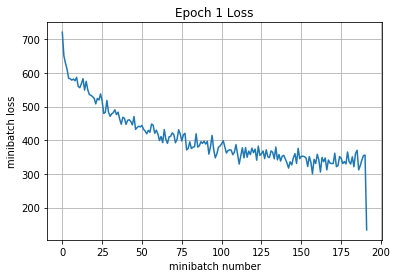

Validation
Epoch 1, Overall loss = 1.77 and accuracy of 0.386

Epoch 1
Training
Iteration 0: with minibatch training loss = 1.21 and accuracy of 0.59
Iteration 100: with minibatch training loss = 1.12 and accuracy of 0.63
Epoch 1, Overall loss = 1.09 and accuracy of 0.635


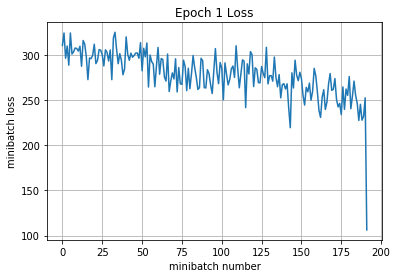

Validation
Epoch 1, Overall loss = 1.85 and accuracy of 0.451

Epoch 2
Training
Iteration 0: with minibatch training loss = 0.887 and accuracy of 0.71
Iteration 100: with minibatch training loss = 0.889 and accuracy of 0.72
Epoch 1, Overall loss = 0.863 and accuracy of 0.72


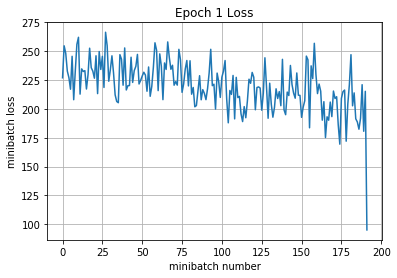

Validation
Epoch 1, Overall loss = 1.33 and accuracy of 0.585

Epoch 3
Training
Iteration 0: with minibatch training loss = 0.809 and accuracy of 0.73
Iteration 100: with minibatch training loss = 0.722 and accuracy of 0.76
Epoch 1, Overall loss = 0.717 and accuracy of 0.769


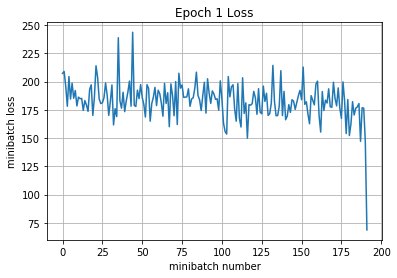

Validation
Epoch 1, Overall loss = 0.968 and accuracy of 0.693

Epoch 4
Training
Iteration 0: with minibatch training loss = 0.595 and accuracy of 0.84
Iteration 100: with minibatch training loss = 0.635 and accuracy of 0.8
Epoch 1, Overall loss = 0.595 and accuracy of 0.811


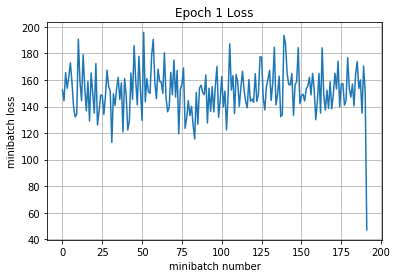

Validation
Epoch 1, Overall loss = 1.08 and accuracy of 0.664

Epoch 5
Training
Iteration 0: with minibatch training loss = 0.517 and accuracy of 0.82
Iteration 100: with minibatch training loss = 0.501 and accuracy of 0.86
Epoch 1, Overall loss = 0.515 and accuracy of 0.837


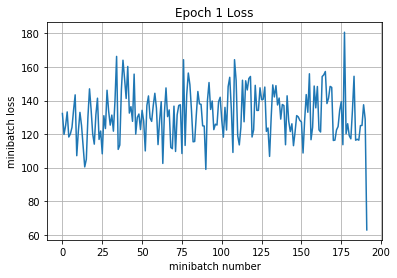

Validation
Epoch 1, Overall loss = 1.12 and accuracy of 0.662

Epoch 6
Training
Iteration 0: with minibatch training loss = 0.41 and accuracy of 0.9
Iteration 100: with minibatch training loss = 0.568 and accuracy of 0.84
Epoch 1, Overall loss = 0.445 and accuracy of 0.861


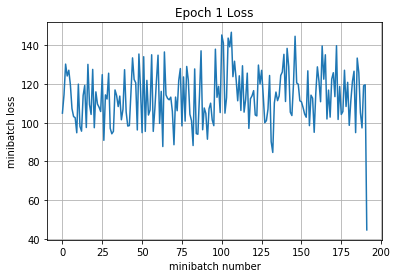

Validation
Epoch 1, Overall loss = 0.931 and accuracy of 0.719

Epoch 7
Training
Iteration 0: with minibatch training loss = 0.369 and accuracy of 0.88
Iteration 100: with minibatch training loss = 0.365 and accuracy of 0.89
Epoch 1, Overall loss = 0.381 and accuracy of 0.882


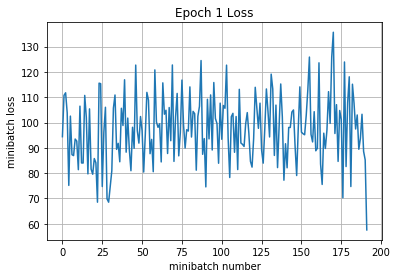

Validation
Epoch 1, Overall loss = 1.03 and accuracy of 0.712

Epoch 8
Training
Iteration 0: with minibatch training loss = 0.233 and accuracy of 0.93
Iteration 100: with minibatch training loss = 0.307 and accuracy of 0.88
Epoch 1, Overall loss = 0.336 and accuracy of 0.894


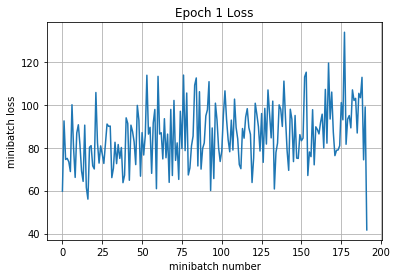

Validation
Epoch 1, Overall loss = 0.801 and accuracy of 0.762

Epoch 9
Training
Iteration 0: with minibatch training loss = 0.214 and accuracy of 0.95
Iteration 100: with minibatch training loss = 0.334 and accuracy of 0.91
Epoch 1, Overall loss = 0.29 and accuracy of 0.911


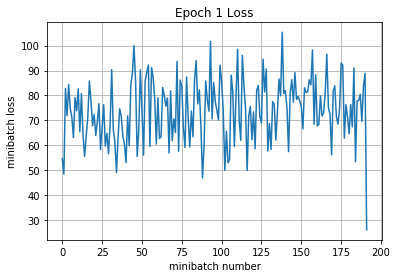

Validation
Epoch 1, Overall loss = 0.754 and accuracy of 0.781

Epoch 10
Training
Iteration 0: with minibatch training loss = 0.245 and accuracy of 0.93
Iteration 100: with minibatch training loss = 0.195 and accuracy of 0.94
Epoch 1, Overall loss = 0.255 and accuracy of 0.921


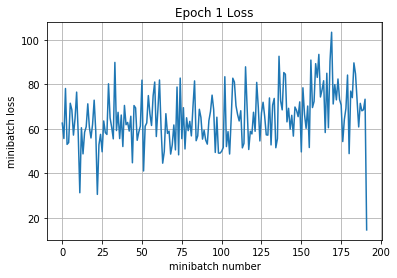

Validation
Epoch 1, Overall loss = 0.66 and accuracy of 0.811

Epoch 11
Training
Iteration 0: with minibatch training loss = 0.15 and accuracy of 0.96
Iteration 100: with minibatch training loss = 0.197 and accuracy of 0.93
Epoch 1, Overall loss = 0.222 and accuracy of 0.932


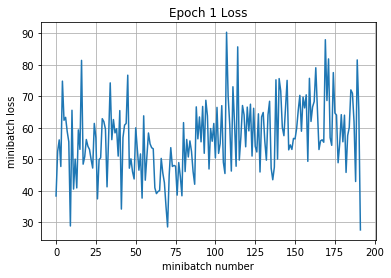

Validation
Epoch 1, Overall loss = 0.911 and accuracy of 0.763

Epoch 12
Training
Iteration 0: with minibatch training loss = 0.227 and accuracy of 0.94
Iteration 100: with minibatch training loss = 0.187 and accuracy of 0.95
Epoch 1, Overall loss = 0.2 and accuracy of 0.939


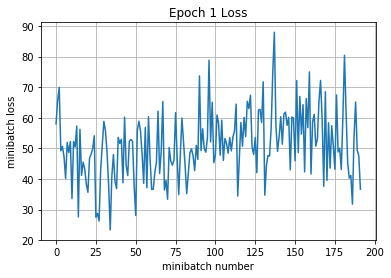

Validation
Epoch 1, Overall loss = 0.673 and accuracy of 0.817

Epoch 13
Training
Iteration 0: with minibatch training loss = 0.179 and accuracy of 0.95
Iteration 100: with minibatch training loss = 0.162 and accuracy of 0.95
Epoch 1, Overall loss = 0.172 and accuracy of 0.947


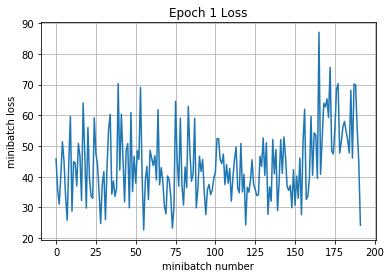

Validation
Epoch 1, Overall loss = 0.755 and accuracy of 0.802

Epoch 14
Training
Iteration 0: with minibatch training loss = 0.146 and accuracy of 0.96
Iteration 100: with minibatch training loss = 0.118 and accuracy of 0.96
Epoch 1, Overall loss = 0.164 and accuracy of 0.949


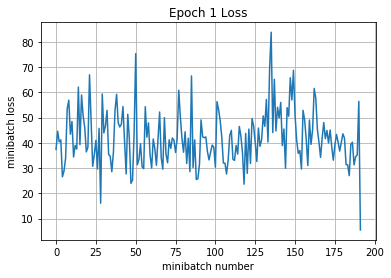

Validation
Epoch 1, Overall loss = 0.819 and accuracy of 0.77

Epoch 15
Training
Iteration 0: with minibatch training loss = 0.0571 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.145 and accuracy of 0.96
Epoch 1, Overall loss = 0.137 and accuracy of 0.958


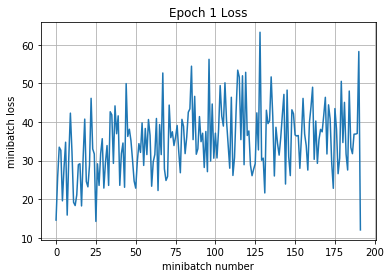

Validation
Epoch 1, Overall loss = 0.902 and accuracy of 0.771

Epoch 16
Training
Iteration 0: with minibatch training loss = 0.166 and accuracy of 0.95
Iteration 100: with minibatch training loss = 0.115 and accuracy of 0.97
Epoch 1, Overall loss = 0.13 and accuracy of 0.96


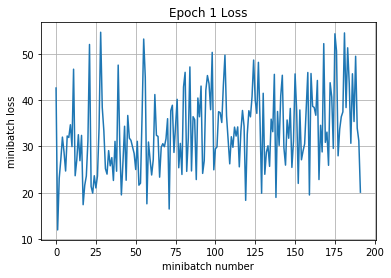

Validation
Epoch 1, Overall loss = 1.04 and accuracy of 0.752

Epoch 17
Training
Iteration 0: with minibatch training loss = 0.0825 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.153 and accuracy of 0.95
Epoch 1, Overall loss = 0.124 and accuracy of 0.961


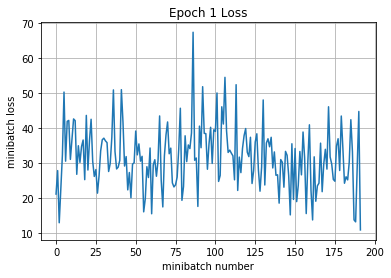

Validation
Epoch 1, Overall loss = 0.727 and accuracy of 0.807

Epoch 18
Training
Iteration 0: with minibatch training loss = 0.0555 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.116 and accuracy of 0.97
Epoch 1, Overall loss = 0.109 and accuracy of 0.968


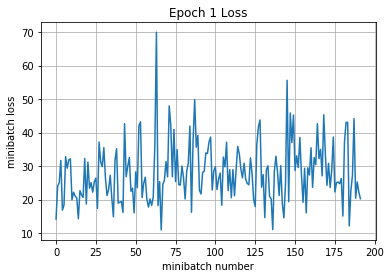

Validation
Epoch 1, Overall loss = 0.726 and accuracy of 0.827

Epoch 19
Training
Iteration 0: with minibatch training loss = 0.0977 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.131 and accuracy of 0.96
Epoch 1, Overall loss = 0.102 and accuracy of 0.969


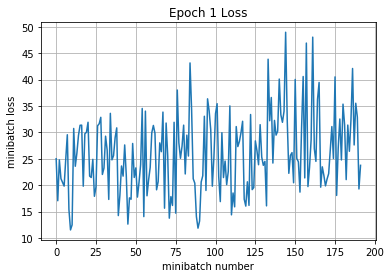

Validation
Epoch 1, Overall loss = 0.73 and accuracy of 0.807

Epoch 20
Training
Iteration 0: with minibatch training loss = 0.0746 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.0812 and accuracy of 0.98
Epoch 1, Overall loss = 0.103 and accuracy of 0.968


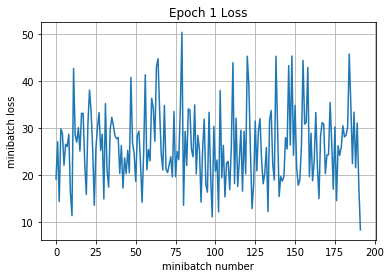

Validation
Epoch 1, Overall loss = 0.891 and accuracy of 0.778

Epoch 21
Training
Iteration 0: with minibatch training loss = 0.0656 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.0853 and accuracy of 0.97
Epoch 1, Overall loss = 0.0917 and accuracy of 0.972


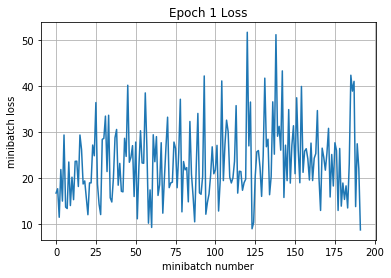

Validation
Epoch 1, Overall loss = 0.673 and accuracy of 0.83

Epoch 22
Training
Iteration 0: with minibatch training loss = 0.0427 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0652 and accuracy of 0.98
Epoch 1, Overall loss = 0.0773 and accuracy of 0.976


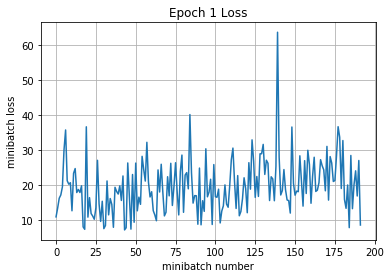

Validation
Epoch 1, Overall loss = 0.849 and accuracy of 0.791

Epoch 23
Training
Iteration 0: with minibatch training loss = 0.0897 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.0655 and accuracy of 0.98
Epoch 1, Overall loss = 0.0778 and accuracy of 0.977


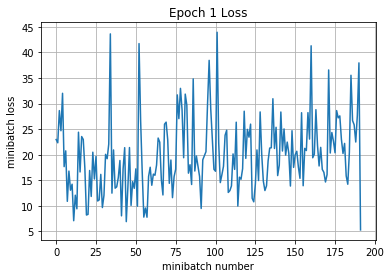

Validation
Epoch 1, Overall loss = 0.741 and accuracy of 0.823

Epoch 24
Training
Iteration 0: with minibatch training loss = 0.091 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.0348 and accuracy of 0.99
Epoch 1, Overall loss = 0.0818 and accuracy of 0.974


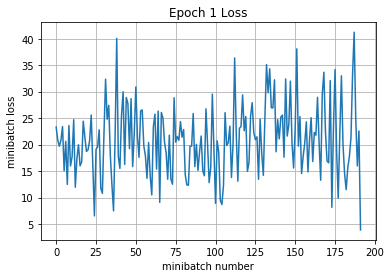

Validation
Epoch 1, Overall loss = 0.76 and accuracy of 0.815

Epoch 25
Training
Iteration 0: with minibatch training loss = 0.056 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.048 and accuracy of 0.98
Epoch 1, Overall loss = 0.0631 and accuracy of 0.981


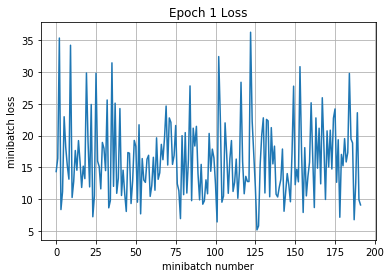

Validation
Epoch 1, Overall loss = 0.819 and accuracy of 0.809

Epoch 26
Training
Iteration 0: with minibatch training loss = 0.0367 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0677 and accuracy of 0.98
Epoch 1, Overall loss = 0.066 and accuracy of 0.98


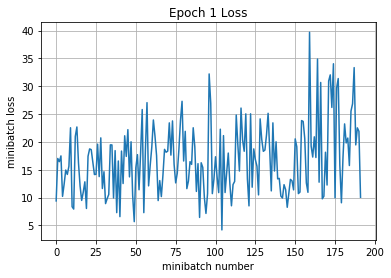

Validation
Epoch 1, Overall loss = 0.737 and accuracy of 0.814

Epoch 27
Training
Iteration 0: with minibatch training loss = 0.0468 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0704 and accuracy of 0.97
Epoch 1, Overall loss = 0.0723 and accuracy of 0.978


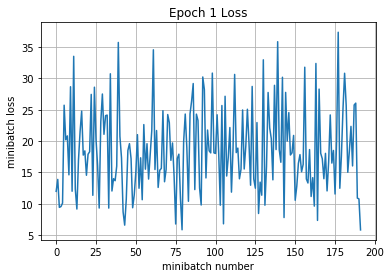

Validation
Epoch 1, Overall loss = 0.779 and accuracy of 0.822

Epoch 28
Training
Iteration 0: with minibatch training loss = 0.0549 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.0588 and accuracy of 0.98
Epoch 1, Overall loss = 0.0654 and accuracy of 0.98


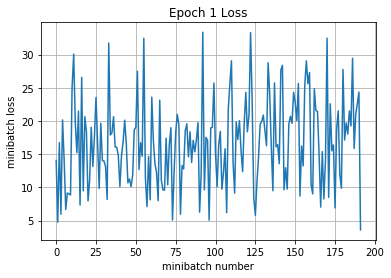

Validation
Epoch 1, Overall loss = 0.829 and accuracy of 0.8

Epoch 29
Training
Iteration 0: with minibatch training loss = 0.0505 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.064 and accuracy of 0.97
Epoch 1, Overall loss = 0.0582 and accuracy of 0.982


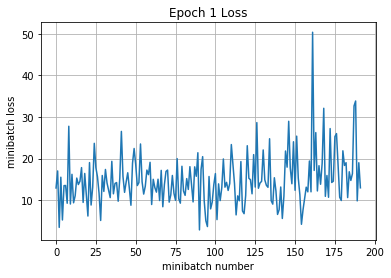

Validation
Epoch 1, Overall loss = 0.922 and accuracy of 0.795

CPU times: user 34min 21s, sys: 6min 31s, total: 40min 52s
Wall time: 34min 5s


In [275]:
%%time
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
# run_model(session, predict, loss_val, Xd, yd,
#               epochs=1, batch_size=64, print_every=100,
#               training=None, plot_losses=False)
try:
    for epoch in range(30):
        print("Epoch {}".format(epoch))
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,256,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,X_val.shape[0])
        print()
except KeyboardInterrupt:
    print("Trainig interrupted")

Epoch 0
Training
Iteration 0: with minibatch training loss = 0.0324 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0974 and accuracy of 0.96
Epoch 1, Overall loss = 0.0577 and accuracy of 0.982


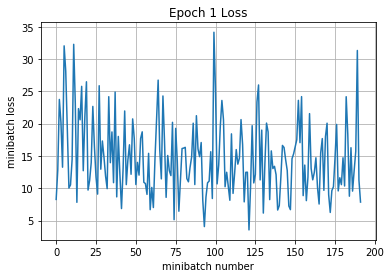

Validation
Epoch 1, Overall loss = 0.811 and accuracy of 0.822

Epoch 1
Training
Iteration 0: with minibatch training loss = 0.0244 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0555 and accuracy of 0.99
Epoch 1, Overall loss = 0.056 and accuracy of 0.982


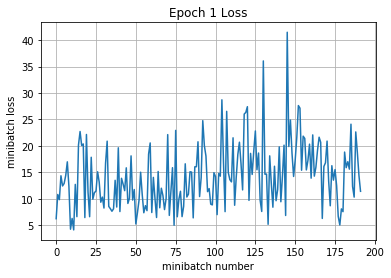

Validation
Epoch 1, Overall loss = 0.633 and accuracy of 0.852

Epoch 2
Training
Iteration 0: with minibatch training loss = 0.05 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0565 and accuracy of 0.98
Epoch 1, Overall loss = 0.0515 and accuracy of 0.984


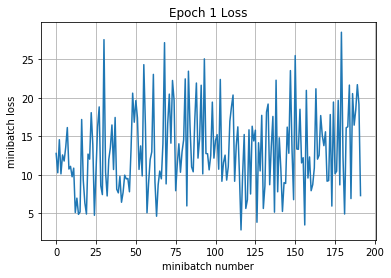

Validation
Epoch 1, Overall loss = 0.813 and accuracy of 0.818

Epoch 3
Training
Iteration 0: with minibatch training loss = 0.014 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0721 and accuracy of 0.98
Epoch 1, Overall loss = 0.0573 and accuracy of 0.982


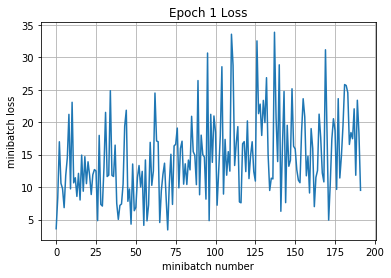

Validation
Epoch 1, Overall loss = 0.817 and accuracy of 0.827

Epoch 4
Training
Iteration 0: with minibatch training loss = 0.0146 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0382 and accuracy of 0.99
Epoch 1, Overall loss = 0.0454 and accuracy of 0.986


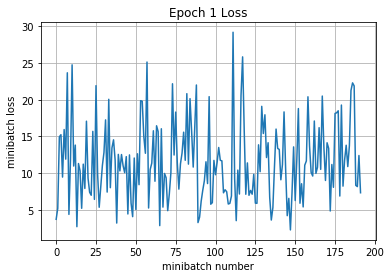

Validation
Epoch 1, Overall loss = 0.881 and accuracy of 0.806

Epoch 5
Training
Iteration 0: with minibatch training loss = 0.0244 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.052 and accuracy of 0.98
Epoch 1, Overall loss = 0.0513 and accuracy of 0.984


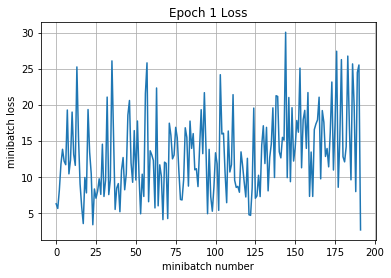

Validation
Epoch 1, Overall loss = 0.834 and accuracy of 0.836

Epoch 6
Training
Iteration 0: with minibatch training loss = 0.0238 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0186 and accuracy of 1
Epoch 1, Overall loss = 0.0436 and accuracy of 0.986


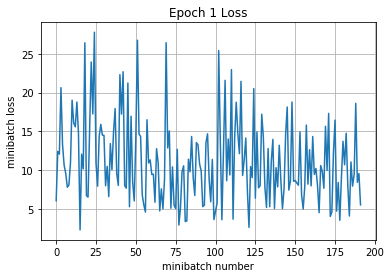

Validation
Epoch 1, Overall loss = 0.719 and accuracy of 0.832

Epoch 7
Training
Iteration 0: with minibatch training loss = 0.0345 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.0435 and accuracy of 0.98
Epoch 1, Overall loss = 0.0429 and accuracy of 0.987


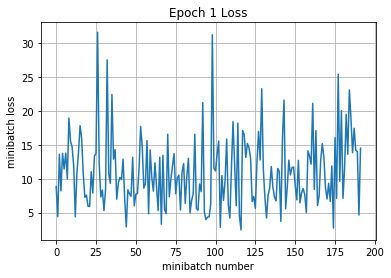

Validation
Epoch 1, Overall loss = 0.93 and accuracy of 0.815

Epoch 8
Training
Iteration 0: with minibatch training loss = 0.0289 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0345 and accuracy of 0.99
Epoch 1, Overall loss = 0.0442 and accuracy of 0.987


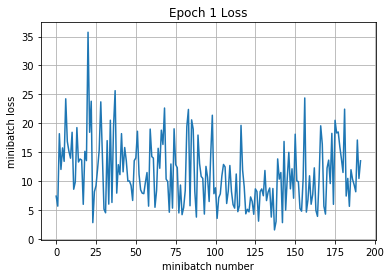

Validation
Epoch 1, Overall loss = 0.75 and accuracy of 0.834

Epoch 9
Training
Iteration 0: with minibatch training loss = 0.0582 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.0555 and accuracy of 0.99
Epoch 1, Overall loss = 0.0467 and accuracy of 0.985


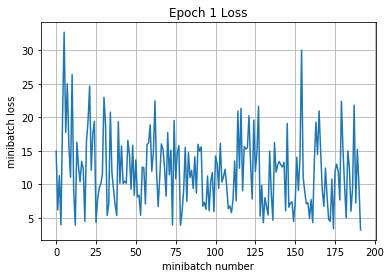

Validation
Epoch 1, Overall loss = 0.774 and accuracy of 0.82

Epoch 10
Training
Iteration 0: with minibatch training loss = 0.0176 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0199 and accuracy of 0.99
Epoch 1, Overall loss = 0.0388 and accuracy of 0.988


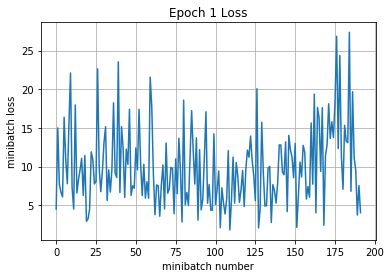

Validation
Epoch 1, Overall loss = 0.815 and accuracy of 0.82

Epoch 11
Training
Iteration 0: with minibatch training loss = 0.0148 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0245 and accuracy of 0.99
Epoch 1, Overall loss = 0.0416 and accuracy of 0.987


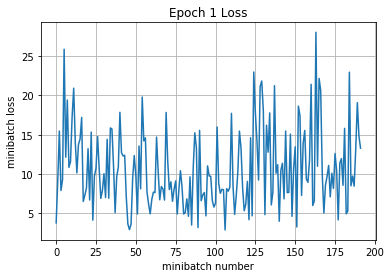

Validation
Epoch 1, Overall loss = 0.844 and accuracy of 0.816

Epoch 12
Training
Iteration 0: with minibatch training loss = 0.0187 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.00981 and accuracy of 1
Epoch 1, Overall loss = 0.0432 and accuracy of 0.986


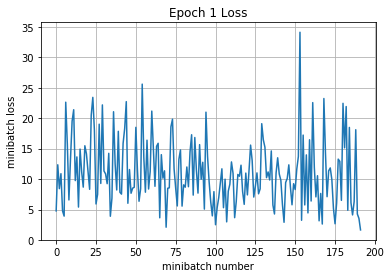

Validation
Epoch 1, Overall loss = 0.858 and accuracy of 0.813

Epoch 13
Training
Iteration 0: with minibatch training loss = 0.0368 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.00826 and accuracy of 1
Epoch 1, Overall loss = 0.0334 and accuracy of 0.99


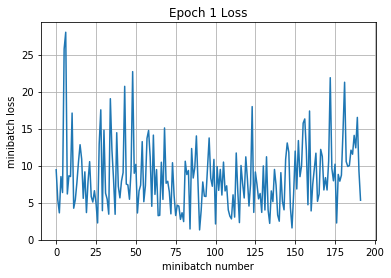

Validation
Epoch 1, Overall loss = 0.771 and accuracy of 0.839

Epoch 14
Training
Iteration 0: with minibatch training loss = 0.0846 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.0448 and accuracy of 0.98
Epoch 1, Overall loss = 0.0396 and accuracy of 0.987


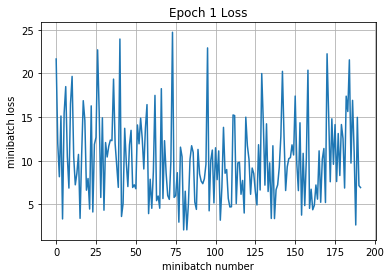

Validation
Epoch 1, Overall loss = 0.793 and accuracy of 0.83

Epoch 15
Training
Iteration 0: with minibatch training loss = 0.0429 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0307 and accuracy of 0.99
Epoch 1, Overall loss = 0.0389 and accuracy of 0.988


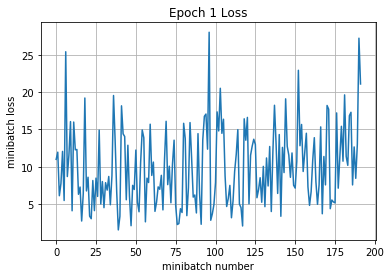

Validation
Epoch 1, Overall loss = 0.931 and accuracy of 0.806

Epoch 16
Training
Iteration 0: with minibatch training loss = 0.0135 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0152 and accuracy of 1
Epoch 1, Overall loss = 0.0376 and accuracy of 0.988


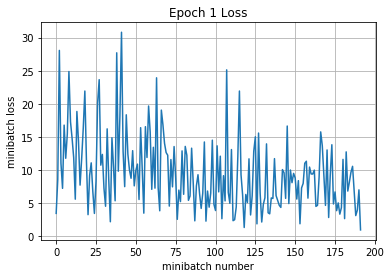

Validation
Epoch 1, Overall loss = 0.728 and accuracy of 0.838

Epoch 17
Training
Iteration 0: with minibatch training loss = 0.0226 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.021 and accuracy of 0.99
Epoch 1, Overall loss = 0.0313 and accuracy of 0.991


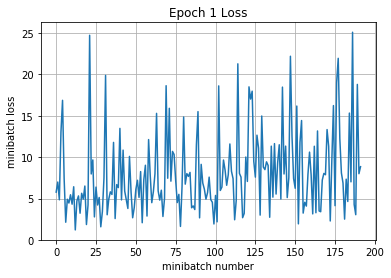

Validation
Epoch 1, Overall loss = 0.775 and accuracy of 0.845

Epoch 18
Training
Iteration 0: with minibatch training loss = 0.0236 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0221 and accuracy of 0.99
Epoch 1, Overall loss = 0.0396 and accuracy of 0.988


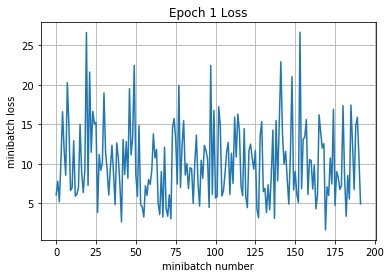

Validation
Epoch 1, Overall loss = 0.809 and accuracy of 0.838

Epoch 19
Training
Iteration 0: with minibatch training loss = 0.00962 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0318 and accuracy of 0.99
Epoch 1, Overall loss = 0.0358 and accuracy of 0.989


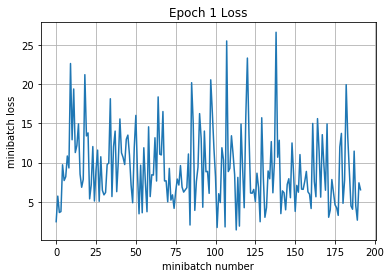

Validation
Epoch 1, Overall loss = 0.725 and accuracy of 0.845

Epoch 20
Training
Iteration 0: with minibatch training loss = 0.00552 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0373 and accuracy of 0.99
Epoch 1, Overall loss = 0.028 and accuracy of 0.992


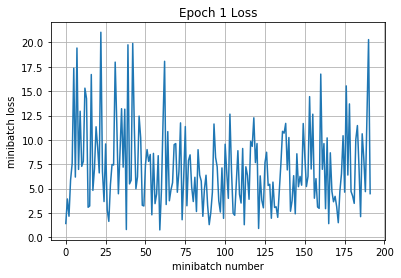

Validation
Epoch 1, Overall loss = 0.836 and accuracy of 0.835

Epoch 21
Training
Iteration 0: with minibatch training loss = 0.00495 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0408 and accuracy of 0.99
Epoch 1, Overall loss = 0.0348 and accuracy of 0.989


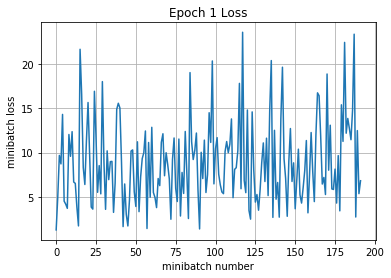

Validation
Epoch 1, Overall loss = 0.818 and accuracy of 0.831

Epoch 22
Training
Iteration 0: with minibatch training loss = 0.00701 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00604 and accuracy of 1
Epoch 1, Overall loss = 0.0298 and accuracy of 0.99


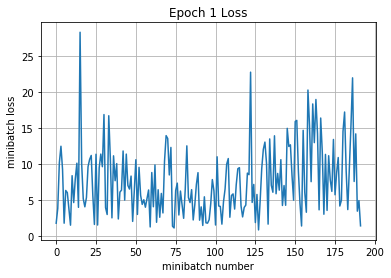

Validation
Epoch 1, Overall loss = 0.847 and accuracy of 0.825

Epoch 23
Training
Iteration 0: with minibatch training loss = 0.0126 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0439 and accuracy of 0.98
Epoch 1, Overall loss = 0.03 and accuracy of 0.99


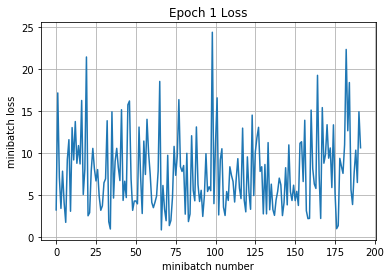

Validation
Epoch 1, Overall loss = 0.913 and accuracy of 0.819

Epoch 24
Training
Iteration 0: with minibatch training loss = 0.0444 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0339 and accuracy of 0.99
Epoch 1, Overall loss = 0.03 and accuracy of 0.99


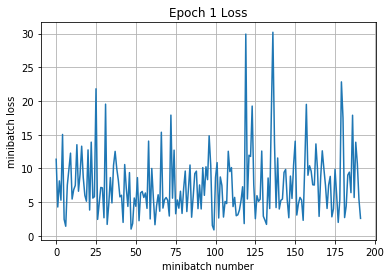

Validation
Epoch 1, Overall loss = 0.777 and accuracy of 0.83

Epoch 25
Training
Iteration 0: with minibatch training loss = 0.034 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0284 and accuracy of 0.99
Epoch 1, Overall loss = 0.0289 and accuracy of 0.991


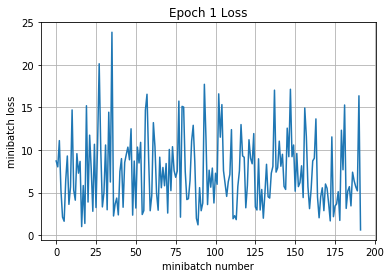

Validation
Epoch 1, Overall loss = 0.863 and accuracy of 0.82

Epoch 26
Training
Iteration 0: with minibatch training loss = 0.00637 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0377 and accuracy of 0.99
Epoch 1, Overall loss = 0.0331 and accuracy of 0.99


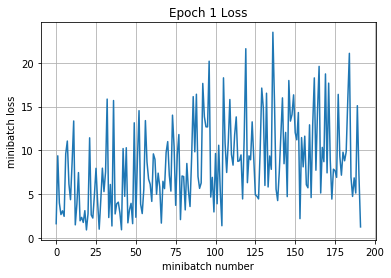

Validation
Epoch 1, Overall loss = 1.09 and accuracy of 0.792

Epoch 27
Training
Iteration 0: with minibatch training loss = 0.0401 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.0188 and accuracy of 0.99
Epoch 1, Overall loss = 0.0296 and accuracy of 0.99


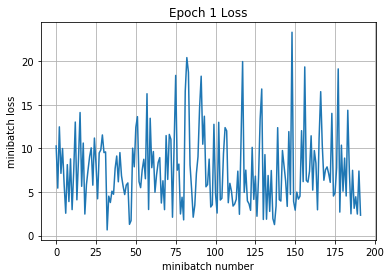

Validation
Epoch 1, Overall loss = 0.934 and accuracy of 0.812

Epoch 28
Training
Iteration 0: with minibatch training loss = 0.0168 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0275 and accuracy of 0.99
Epoch 1, Overall loss = 0.0219 and accuracy of 0.993


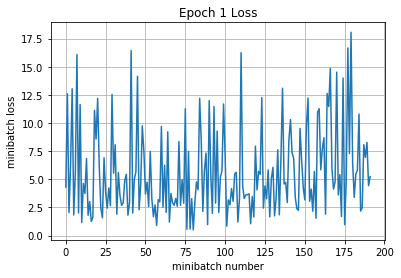

Validation
Epoch 1, Overall loss = 0.82 and accuracy of 0.838

Epoch 29
Training
Iteration 0: with minibatch training loss = 0.0706 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.0108 and accuracy of 1
Epoch 1, Overall loss = 0.0242 and accuracy of 0.992


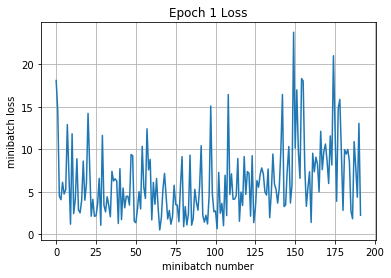

Validation
Epoch 1, Overall loss = 0.877 and accuracy of 0.826

Epoch 30
Training
Iteration 0: with minibatch training loss = 0.0194 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0252 and accuracy of 0.99
Epoch 1, Overall loss = 0.0271 and accuracy of 0.992


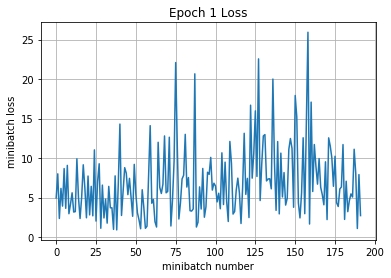

Validation
Epoch 1, Overall loss = 0.872 and accuracy of 0.828

Epoch 31
Training
Iteration 0: with minibatch training loss = 0.0272 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.0269 and accuracy of 0.99
Epoch 1, Overall loss = 0.029 and accuracy of 0.991


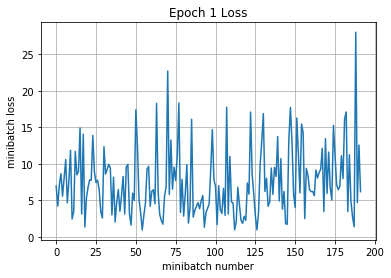

Validation
Epoch 1, Overall loss = 0.742 and accuracy of 0.852

Epoch 32
Training
Iteration 0: with minibatch training loss = 0.0125 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0272 and accuracy of 0.99
Epoch 1, Overall loss = 0.0247 and accuracy of 0.992


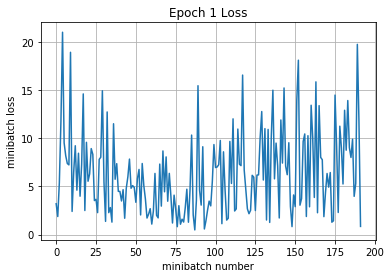

Validation
Epoch 1, Overall loss = 0.715 and accuracy of 0.853

Epoch 33
Training
Iteration 0: with minibatch training loss = 0.00604 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0155 and accuracy of 1
Epoch 1, Overall loss = 0.0215 and accuracy of 0.993


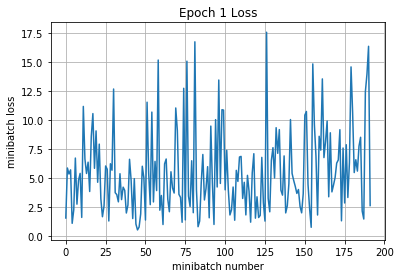

Validation
Epoch 1, Overall loss = 0.864 and accuracy of 0.824

Epoch 34
Training
Iteration 0: with minibatch training loss = 0.027 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0366 and accuracy of 0.99
Epoch 1, Overall loss = 0.0284 and accuracy of 0.991


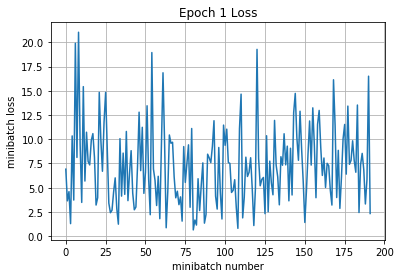

Validation
Epoch 1, Overall loss = 0.793 and accuracy of 0.839

Epoch 35
Training
Iteration 0: with minibatch training loss = 0.0165 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0343 and accuracy of 0.99
Epoch 1, Overall loss = 0.0218 and accuracy of 0.993


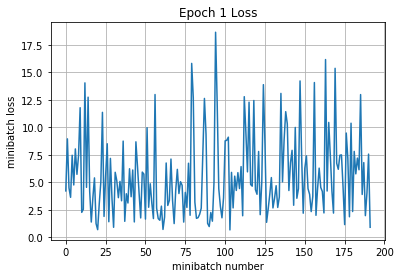

Validation
Epoch 1, Overall loss = 0.738 and accuracy of 0.858

Epoch 36
Training
Iteration 0: with minibatch training loss = 0.0194 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0151 and accuracy of 1
Epoch 1, Overall loss = 0.0189 and accuracy of 0.994


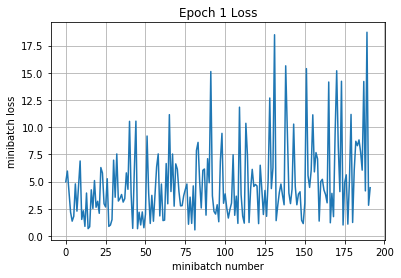

Validation
Epoch 1, Overall loss = 0.92 and accuracy of 0.828

Epoch 37
Training
Iteration 0: with minibatch training loss = 0.0645 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.0106 and accuracy of 1
Epoch 1, Overall loss = 0.0244 and accuracy of 0.992


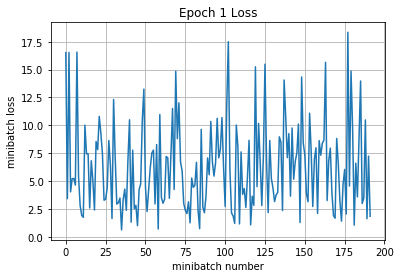

Validation
Epoch 1, Overall loss = 0.894 and accuracy of 0.826

Epoch 38
Training
Iteration 0: with minibatch training loss = 0.011 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0314 and accuracy of 0.99
Epoch 1, Overall loss = 0.0226 and accuracy of 0.993


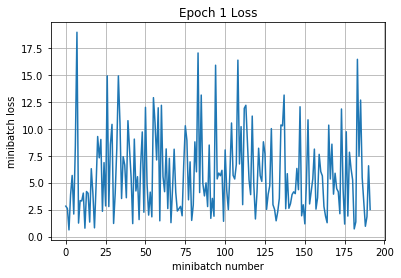

Validation
Epoch 1, Overall loss = 0.942 and accuracy of 0.823

Epoch 39
Training
Iteration 0: with minibatch training loss = 0.00986 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0168 and accuracy of 0.99
Epoch 1, Overall loss = 0.0204 and accuracy of 0.994


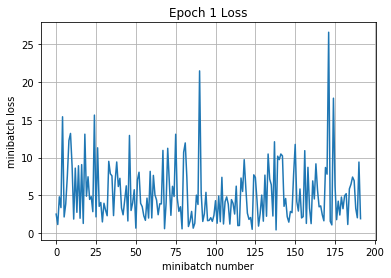

Validation
Epoch 1, Overall loss = 0.862 and accuracy of 0.835

Epoch 40
Training
Iteration 0: with minibatch training loss = 0.00684 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00431 and accuracy of 1
Epoch 1, Overall loss = 0.0245 and accuracy of 0.992


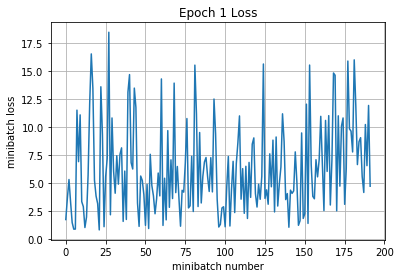

Validation
Epoch 1, Overall loss = 0.858 and accuracy of 0.84

Epoch 41
Training
Iteration 0: with minibatch training loss = 0.0272 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0146 and accuracy of 1
Epoch 1, Overall loss = 0.0209 and accuracy of 0.993


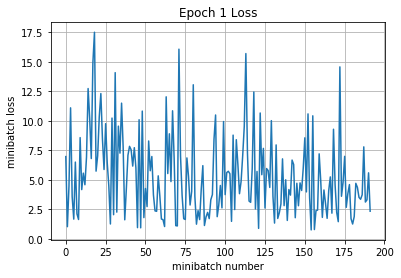

Validation
Epoch 1, Overall loss = 0.762 and accuracy of 0.832

Epoch 42
Training
Iteration 0: with minibatch training loss = 0.00828 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00894 and accuracy of 1
Epoch 1, Overall loss = 0.0231 and accuracy of 0.992


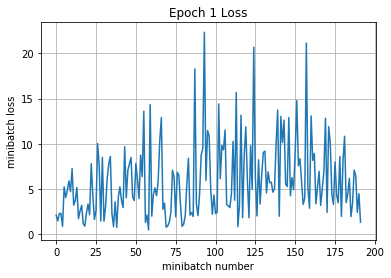

Validation
Epoch 1, Overall loss = 0.823 and accuracy of 0.839

Epoch 43
Training
Iteration 0: with minibatch training loss = 0.0296 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.00468 and accuracy of 1
Epoch 1, Overall loss = 0.0248 and accuracy of 0.992


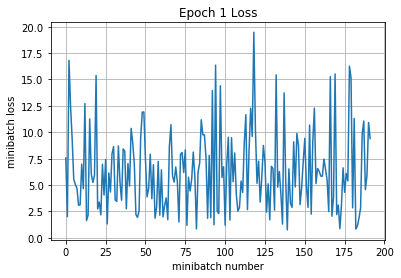

Validation
Epoch 1, Overall loss = 0.8 and accuracy of 0.84

Epoch 44
Training
Iteration 0: with minibatch training loss = 0.00207 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00744 and accuracy of 1
Epoch 1, Overall loss = 0.0168 and accuracy of 0.995


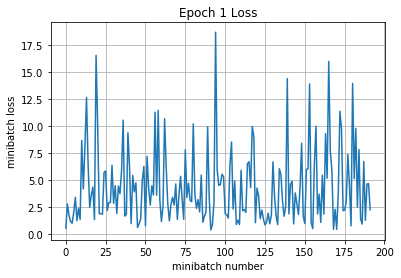

Validation
Epoch 1, Overall loss = 0.853 and accuracy of 0.84

Epoch 45
Training
Iteration 0: with minibatch training loss = 0.0192 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0369 and accuracy of 0.99
Epoch 1, Overall loss = 0.0185 and accuracy of 0.994


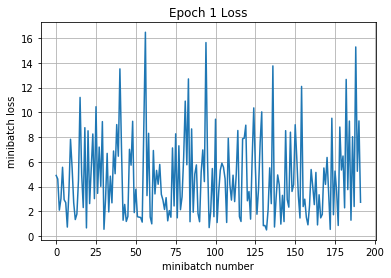

Validation
Epoch 1, Overall loss = 0.772 and accuracy of 0.843

Epoch 46
Training
Iteration 0: with minibatch training loss = 0.00957 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0183 and accuracy of 0.99
Epoch 1, Overall loss = 0.0236 and accuracy of 0.992


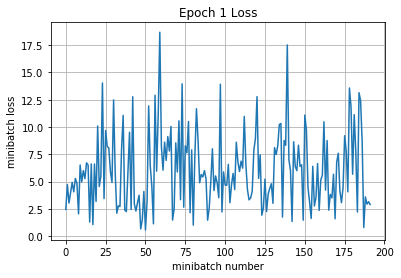

Validation
Epoch 1, Overall loss = 0.833 and accuracy of 0.843

Epoch 47
Training
Iteration 0: with minibatch training loss = 0.0137 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.00685 and accuracy of 1
Epoch 1, Overall loss = 0.018 and accuracy of 0.994


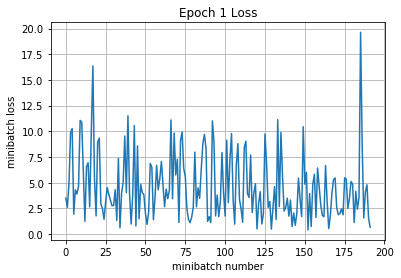

Validation
Epoch 1, Overall loss = 0.826 and accuracy of 0.851

Epoch 48
Training
Iteration 0: with minibatch training loss = 0.0187 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.026 and accuracy of 0.99
Epoch 1, Overall loss = 0.0192 and accuracy of 0.994


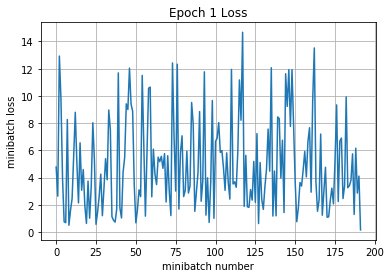

Validation
Epoch 1, Overall loss = 0.836 and accuracy of 0.835

Epoch 49
Training
Iteration 0: with minibatch training loss = 0.00525 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00342 and accuracy of 1
Epoch 1, Overall loss = 0.0152 and accuracy of 0.995


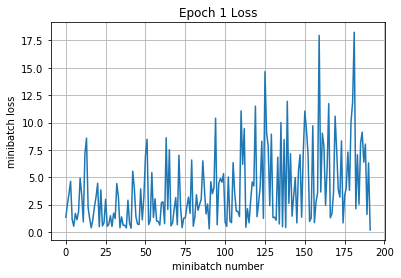

Validation
Epoch 1, Overall loss = 0.842 and accuracy of 0.839

Epoch 50
Training
Iteration 0: with minibatch training loss = 0.0527 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.0253 and accuracy of 0.99
Epoch 1, Overall loss = 0.0239 and accuracy of 0.992


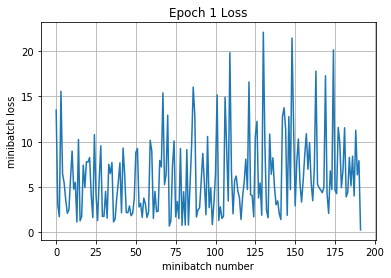

Validation
Epoch 1, Overall loss = 0.797 and accuracy of 0.848

Epoch 51
Training
Iteration 0: with minibatch training loss = 0.0122 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0145 and accuracy of 0.99
Epoch 1, Overall loss = 0.0171 and accuracy of 0.995


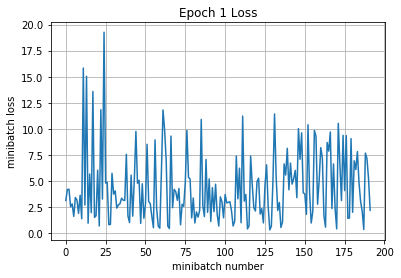

Validation
Epoch 1, Overall loss = 0.93 and accuracy of 0.814

Epoch 52
Training
Iteration 0: with minibatch training loss = 0.00297 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0425 and accuracy of 0.98
Epoch 1, Overall loss = 0.017 and accuracy of 0.995


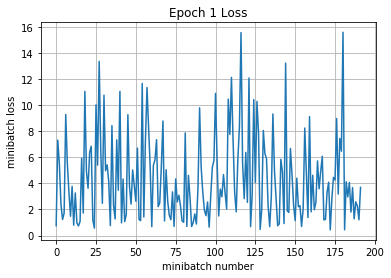

Validation
Epoch 1, Overall loss = 0.809 and accuracy of 0.848

Epoch 53
Training
Iteration 0: with minibatch training loss = 0.007 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0294 and accuracy of 0.99
Epoch 1, Overall loss = 0.0197 and accuracy of 0.993


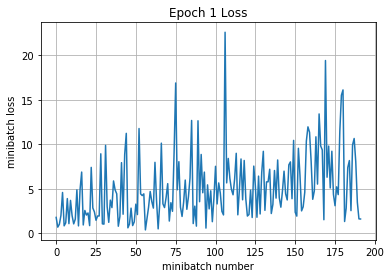

Validation
Epoch 1, Overall loss = 0.898 and accuracy of 0.83

Epoch 54
Training
Iteration 0: with minibatch training loss = 0.00853 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0193 and accuracy of 1
Epoch 1, Overall loss = 0.0154 and accuracy of 0.995


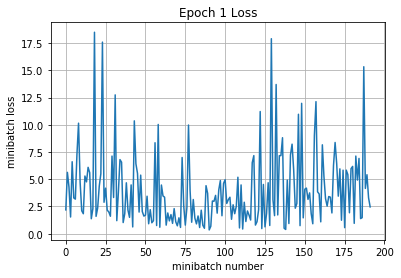

Validation
Epoch 1, Overall loss = 0.968 and accuracy of 0.822

Epoch 55
Training
Iteration 0: with minibatch training loss = 0.00684 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00763 and accuracy of 1
Epoch 1, Overall loss = 0.0159 and accuracy of 0.995


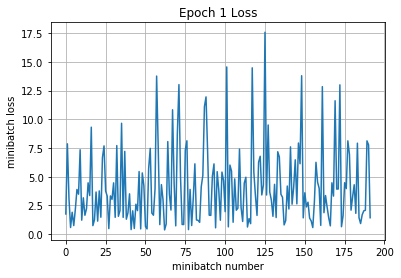

Validation
Epoch 1, Overall loss = 0.94 and accuracy of 0.828

Epoch 56
Training
Iteration 0: with minibatch training loss = 0.0434 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0327 and accuracy of 0.99
Epoch 1, Overall loss = 0.0162 and accuracy of 0.995


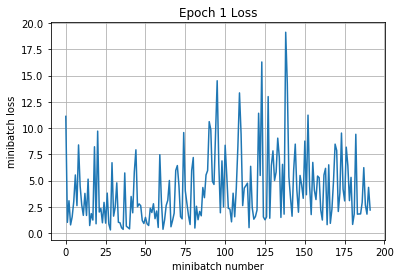

Validation
Epoch 1, Overall loss = 0.749 and accuracy of 0.846

Epoch 57
Training
Iteration 0: with minibatch training loss = 0.00319 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0227 and accuracy of 0.99
Epoch 1, Overall loss = 0.021 and accuracy of 0.994


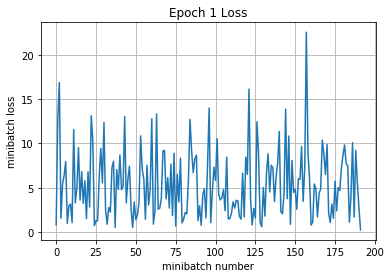

Validation
Epoch 1, Overall loss = 0.845 and accuracy of 0.836

Epoch 58
Training
Iteration 0: with minibatch training loss = 0.0193 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.00395 and accuracy of 1
Epoch 1, Overall loss = 0.0149 and accuracy of 0.995


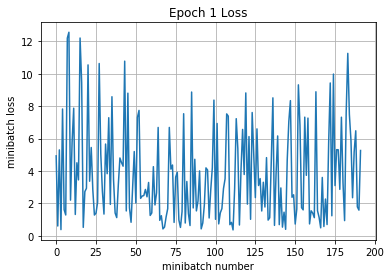

Validation
Epoch 1, Overall loss = 0.892 and accuracy of 0.846

Epoch 59
Training
Iteration 0: with minibatch training loss = 0.0167 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0343 and accuracy of 0.99
Epoch 1, Overall loss = 0.0159 and accuracy of 0.995


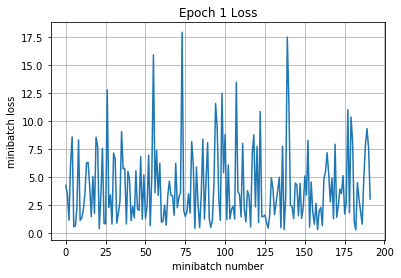

Validation
Epoch 1, Overall loss = 0.85 and accuracy of 0.836

Epoch 60
Training
Iteration 0: with minibatch training loss = 0.0258 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0192 and accuracy of 1
Epoch 1, Overall loss = 0.0144 and accuracy of 0.995


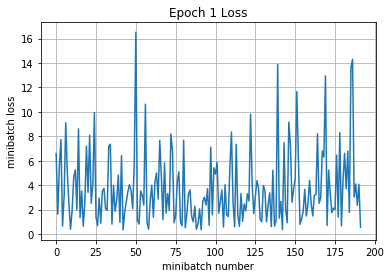

Validation
Epoch 1, Overall loss = 0.859 and accuracy of 0.841

Epoch 61
Training
Iteration 0: with minibatch training loss = 0.0134 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0149 and accuracy of 1
Epoch 1, Overall loss = 0.0172 and accuracy of 0.995


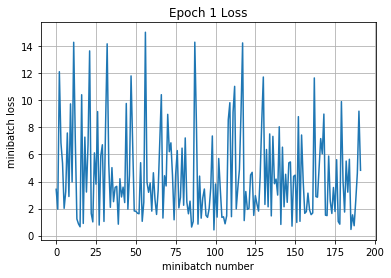

Validation
Epoch 1, Overall loss = 0.868 and accuracy of 0.839

Epoch 62
Training
Iteration 0: with minibatch training loss = 0.00463 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00632 and accuracy of 1
Epoch 1, Overall loss = 0.0199 and accuracy of 0.994


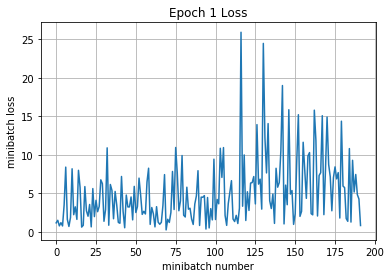

Validation
Epoch 1, Overall loss = 0.937 and accuracy of 0.83

Epoch 63
Training
Iteration 0: with minibatch training loss = 0.017 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0185 and accuracy of 1
Epoch 1, Overall loss = 0.018 and accuracy of 0.994


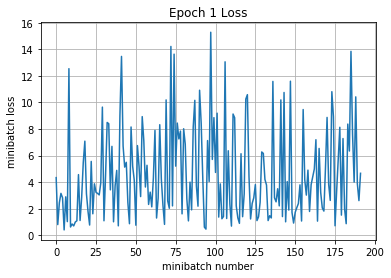

Validation
Epoch 1, Overall loss = 0.79 and accuracy of 0.836

Epoch 64
Training
Iteration 0: with minibatch training loss = 0.0154 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.00622 and accuracy of 1
Epoch 1, Overall loss = 0.0162 and accuracy of 0.995


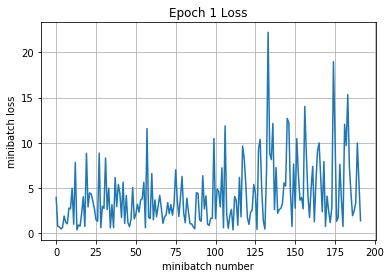

Validation
Epoch 1, Overall loss = 1.02 and accuracy of 0.82

Epoch 65
Training
Iteration 0: with minibatch training loss = 0.0363 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0304 and accuracy of 0.99
Epoch 1, Overall loss = 0.0157 and accuracy of 0.995


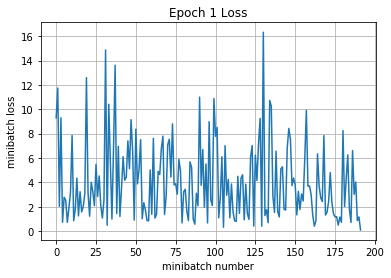

Validation
Epoch 1, Overall loss = 0.727 and accuracy of 0.855

Epoch 66
Training
Iteration 0: with minibatch training loss = 0.0124 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0111 and accuracy of 1
Epoch 1, Overall loss = 0.0115 and accuracy of 0.996


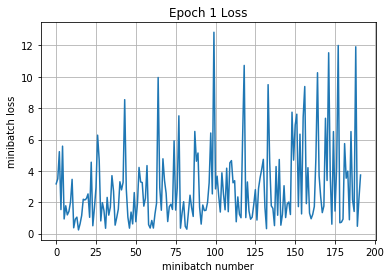

Validation
Epoch 1, Overall loss = 0.998 and accuracy of 0.818

Epoch 67
Training
Iteration 0: with minibatch training loss = 0.014 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0112 and accuracy of 1
Epoch 1, Overall loss = 0.0191 and accuracy of 0.994


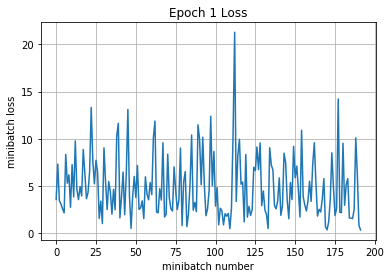

Validation
Epoch 1, Overall loss = 0.88 and accuracy of 0.836

Epoch 68
Training
Iteration 0: with minibatch training loss = 0.00988 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00983 and accuracy of 1
Epoch 1, Overall loss = 0.0132 and accuracy of 0.996


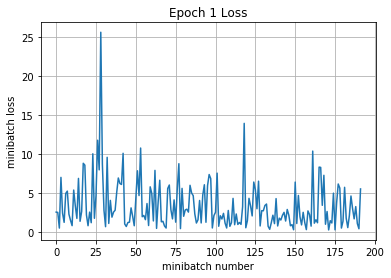

Validation
Epoch 1, Overall loss = 0.834 and accuracy of 0.849

Epoch 69
Training
Iteration 0: with minibatch training loss = 0.00141 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0022 and accuracy of 1
Epoch 1, Overall loss = 0.0128 and accuracy of 0.996


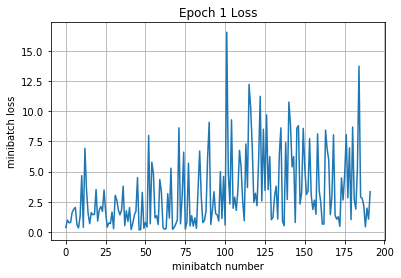

Validation
Epoch 1, Overall loss = 0.889 and accuracy of 0.843

Epoch 70
Training
Iteration 0: with minibatch training loss = 0.00451 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00132 and accuracy of 1
Epoch 1, Overall loss = 0.012 and accuracy of 0.996


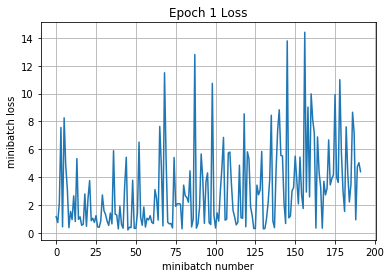

Validation
Epoch 1, Overall loss = 0.927 and accuracy of 0.837

Epoch 71
Training
Iteration 0: with minibatch training loss = 0.0214 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.00777 and accuracy of 1
Epoch 1, Overall loss = 0.0167 and accuracy of 0.995


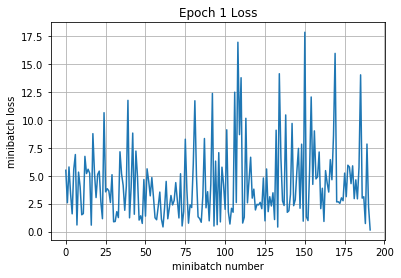

Validation
Epoch 1, Overall loss = 0.873 and accuracy of 0.842

Epoch 72
Training
Iteration 0: with minibatch training loss = 0.019 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.00328 and accuracy of 1
Epoch 1, Overall loss = 0.0121 and accuracy of 0.996


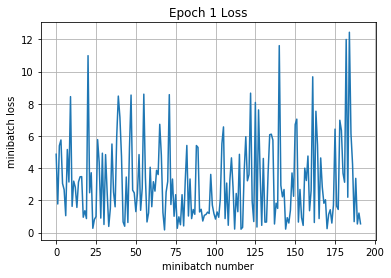

Validation
Epoch 1, Overall loss = 0.898 and accuracy of 0.832

Epoch 73
Training
Iteration 0: with minibatch training loss = 0.00596 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00524 and accuracy of 1
Epoch 1, Overall loss = 0.014 and accuracy of 0.996


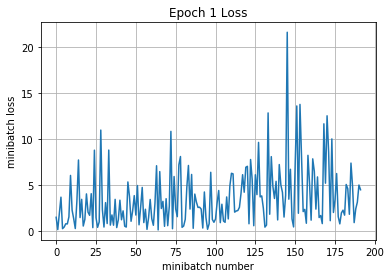

Validation
Epoch 1, Overall loss = 0.956 and accuracy of 0.831

Epoch 74
Training
Iteration 0: with minibatch training loss = 0.0285 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0296 and accuracy of 0.99
Epoch 1, Overall loss = 0.0137 and accuracy of 0.996


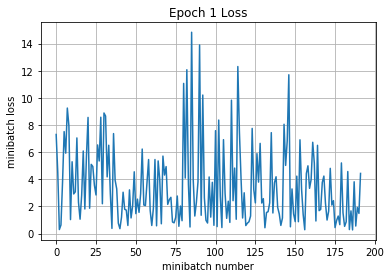

Validation
Epoch 1, Overall loss = 0.866 and accuracy of 0.846

Epoch 75
Training
Iteration 0: with minibatch training loss = 0.0187 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0218 and accuracy of 0.99
Epoch 1, Overall loss = 0.0128 and accuracy of 0.996


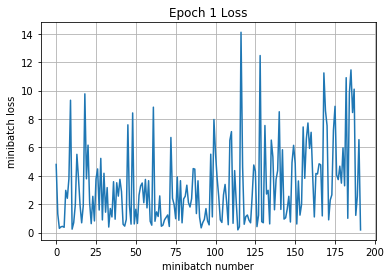

Validation
Epoch 1, Overall loss = 0.9 and accuracy of 0.839

Epoch 76
Training
Iteration 0: with minibatch training loss = 0.0114 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0219 and accuracy of 0.99
Epoch 1, Overall loss = 0.0153 and accuracy of 0.995


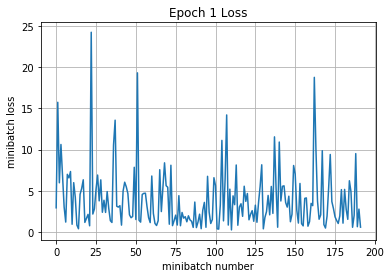

Validation
Epoch 1, Overall loss = 0.916 and accuracy of 0.839

Epoch 77
Training
Iteration 0: with minibatch training loss = 0.0306 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0177 and accuracy of 1
Epoch 1, Overall loss = 0.0134 and accuracy of 0.996


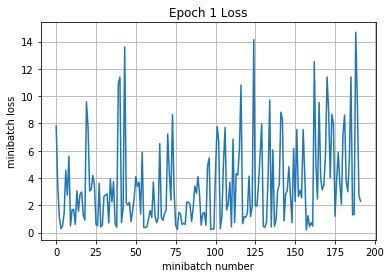

Validation
Epoch 1, Overall loss = 0.952 and accuracy of 0.822

Epoch 78
Training
Iteration 0: with minibatch training loss = 0.0029 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0299 and accuracy of 0.99
Epoch 1, Overall loss = 0.0175 and accuracy of 0.994


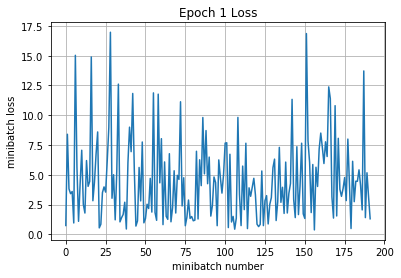

Validation
Epoch 1, Overall loss = 0.859 and accuracy of 0.841

Epoch 79
Training
Iteration 0: with minibatch training loss = 0.00256 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00205 and accuracy of 1
Epoch 1, Overall loss = 0.0149 and accuracy of 0.995


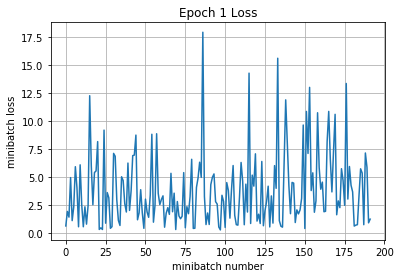

Validation
Epoch 1, Overall loss = 0.837 and accuracy of 0.853

Epoch 80
Training
Iteration 0: with minibatch training loss = 0.0112 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.00353 and accuracy of 1
Epoch 1, Overall loss = 0.00964 and accuracy of 0.997


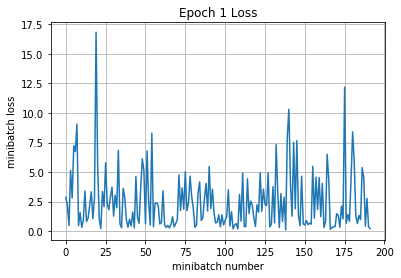

Validation
Epoch 1, Overall loss = 0.763 and accuracy of 0.853

Epoch 81
Training
Iteration 0: with minibatch training loss = 0.00111 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0254 and accuracy of 0.99
Epoch 1, Overall loss = 0.0126 and accuracy of 0.996


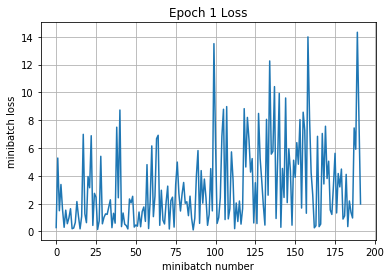

Validation
Epoch 1, Overall loss = 0.882 and accuracy of 0.838

Epoch 82
Training
Iteration 0: with minibatch training loss = 0.00907 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0337 and accuracy of 0.99
Epoch 1, Overall loss = 0.0151 and accuracy of 0.995


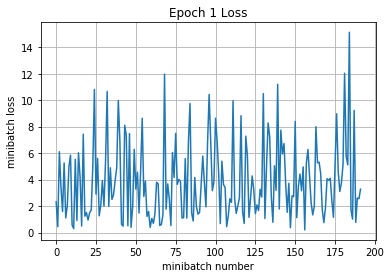

Validation
Epoch 1, Overall loss = 0.878 and accuracy of 0.842

Epoch 83
Training
Iteration 0: with minibatch training loss = 0.00423 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00454 and accuracy of 1
Epoch 1, Overall loss = 0.0108 and accuracy of 0.996


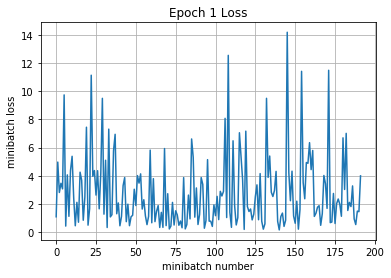

Validation
Epoch 1, Overall loss = 0.89 and accuracy of 0.831

Epoch 84
Training
Iteration 0: with minibatch training loss = 0.00941 and accuracy of 0.99
Iteration 100: with minibatch training loss = 0.0248 and accuracy of 1
Epoch 1, Overall loss = 0.0128 and accuracy of 0.996


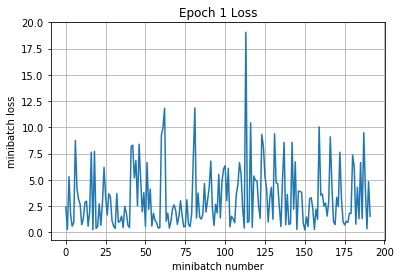

Validation
Epoch 1, Overall loss = 0.868 and accuracy of 0.846

Epoch 85
Training
Iteration 0: with minibatch training loss = 0.000922 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0116 and accuracy of 1
Epoch 1, Overall loss = 0.0148 and accuracy of 0.995


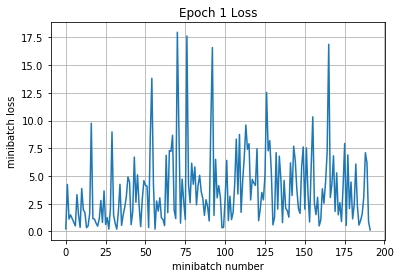

Validation
Epoch 1, Overall loss = 0.849 and accuracy of 0.836

Epoch 86
Training
Iteration 0: with minibatch training loss = 0.0026 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00369 and accuracy of 1
Epoch 1, Overall loss = 0.0104 and accuracy of 0.997


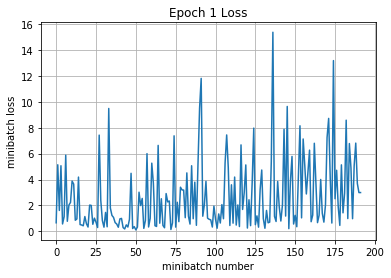

Validation
Epoch 1, Overall loss = 0.952 and accuracy of 0.838

Epoch 87
Training
Iteration 0: with minibatch training loss = 0.00145 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0359 and accuracy of 0.98
Epoch 1, Overall loss = 0.0135 and accuracy of 0.996


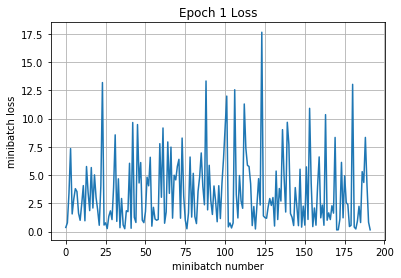

Validation
Epoch 1, Overall loss = 0.854 and accuracy of 0.847

Epoch 88
Training
Iteration 0: with minibatch training loss = 0.000855 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00228 and accuracy of 1
Epoch 1, Overall loss = 0.0113 and accuracy of 0.996


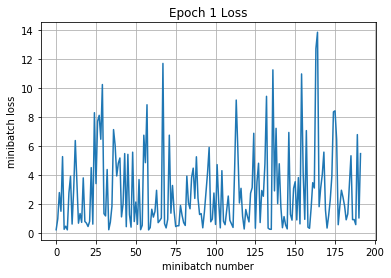

Validation
Epoch 1, Overall loss = 0.861 and accuracy of 0.842

Epoch 89
Training
Iteration 0: with minibatch training loss = 0.00951 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0223 and accuracy of 1
Epoch 1, Overall loss = 0.0134 and accuracy of 0.996


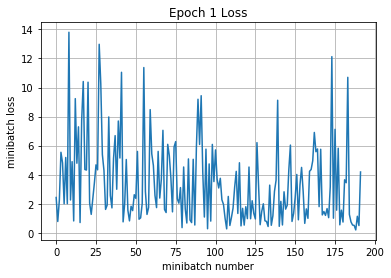

Validation
Epoch 1, Overall loss = 0.869 and accuracy of 0.852

Epoch 90
Training
Iteration 0: with minibatch training loss = 0.00126 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0172 and accuracy of 0.99
Epoch 1, Overall loss = 0.0103 and accuracy of 0.997


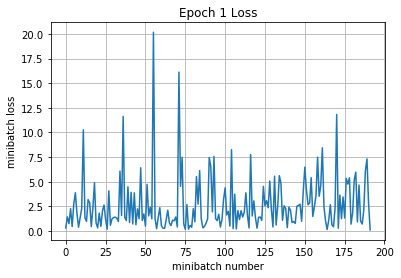

Validation
Epoch 1, Overall loss = 0.962 and accuracy of 0.827

Epoch 91
Training
Iteration 0: with minibatch training loss = 0.0103 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00353 and accuracy of 1
Epoch 1, Overall loss = 0.0076 and accuracy of 0.998


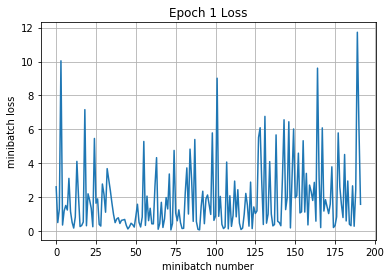

Validation
Epoch 1, Overall loss = 0.935 and accuracy of 0.834

Epoch 92
Training
Iteration 0: with minibatch training loss = 0.000776 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00275 and accuracy of 1
Epoch 1, Overall loss = 0.0105 and accuracy of 0.997


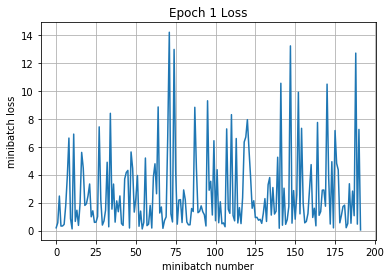

Validation
Epoch 1, Overall loss = 0.957 and accuracy of 0.83

Epoch 93
Training
Iteration 0: with minibatch training loss = 0.00172 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0125 and accuracy of 1
Epoch 1, Overall loss = 0.015 and accuracy of 0.995


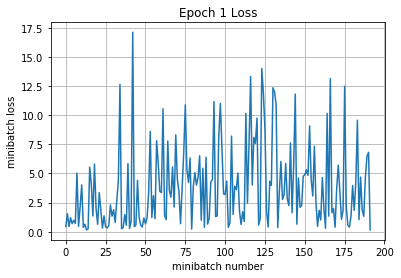

Validation
Epoch 1, Overall loss = 0.928 and accuracy of 0.831

Epoch 94
Training
Iteration 0: with minibatch training loss = 0.00532 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00751 and accuracy of 1
Epoch 1, Overall loss = 0.0109 and accuracy of 0.996


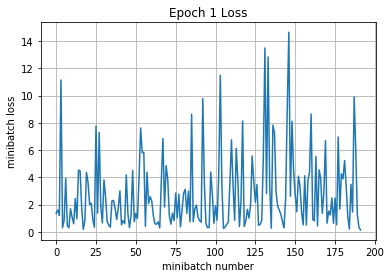

Validation
Epoch 1, Overall loss = 0.84 and accuracy of 0.844

Epoch 95
Training
Iteration 0: with minibatch training loss = 0.0059 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00141 and accuracy of 1
Epoch 1, Overall loss = 0.00989 and accuracy of 0.997


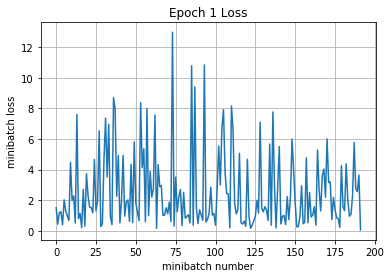

Validation
Epoch 1, Overall loss = 0.823 and accuracy of 0.849

Epoch 96
Training
Iteration 0: with minibatch training loss = 0.00538 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00565 and accuracy of 1
Epoch 1, Overall loss = 0.0128 and accuracy of 0.996


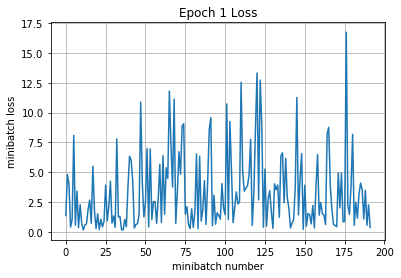

Validation
Epoch 1, Overall loss = 0.805 and accuracy of 0.86

Epoch 97
Training
Iteration 0: with minibatch training loss = 0.00275 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0263 and accuracy of 0.99
Epoch 1, Overall loss = 0.0106 and accuracy of 0.997


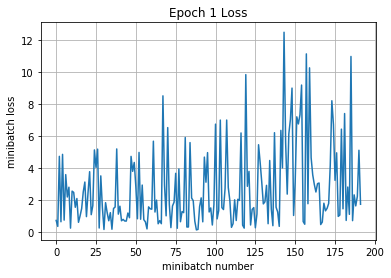

Validation
Epoch 1, Overall loss = 0.876 and accuracy of 0.836

Epoch 98
Training
Iteration 0: with minibatch training loss = 0.00286 and accuracy of 1
Iteration 100: with minibatch training loss = 0.0013 and accuracy of 1
Epoch 1, Overall loss = 0.0112 and accuracy of 0.997


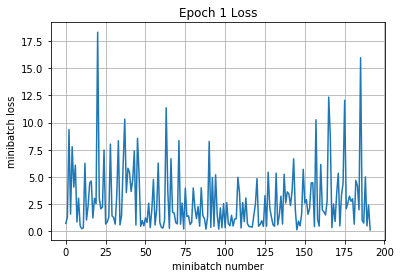

Validation
Epoch 1, Overall loss = 0.843 and accuracy of 0.853

Epoch 99
Training
Iteration 0: with minibatch training loss = 0.00153 and accuracy of 1
Iteration 100: with minibatch training loss = 0.00831 and accuracy of 1
Epoch 1, Overall loss = 0.00867 and accuracy of 0.997


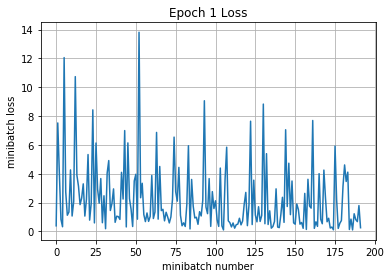

Validation
Epoch 1, Overall loss = 0.862 and accuracy of 0.852



In [276]:
try:
    for epoch in range(100):
        print("Epoch {}".format(epoch))
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,256,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,X_val.shape[0])
        print()
except KeyboardInterrupt:
    print("Trainig interrupted")

In [278]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.0152 and accuracy of 0.995
Validation
Epoch 1, Overall loss = 0.862 and accuracy of 0.852


(0.86161526489257811, 0.85199999999999998)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

**81% val, 80.7% test:** *Used 5 (conv layers + max pooling + relu + batch_norm) with filter_size 3 (64-128-256-512-512 filters), then 4 fully connected layers (2048-1024-512-10), all layers were trained with dropout probability 0.8 for 60 epochs (batch size 512). AdamOptimizer, Learning_rate=1e-4*

**81.3% val, 79.7% test:** *Used model_dense, AdamOptimizer, lr=1e-3, 30 epochs (with 1e-4 converges to different minima, val ~65-75)*

**85.2% val, 83.9% test:** *Used model_residual, AdamOptimizer, lr=1e-3, 130 epochs* (tried YellowFin, but converges to different minima, val ~65-75)*

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [279]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 0.87 and accuracy of 0.839


(0.86952919058799749, 0.83860000000000001)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

ResNet, DenseNet, tried ResNet with YellowFin optimizer